<a href="https://colab.research.google.com/github/Johny85/World-of-Scripts/blob/master/IISC_AQI_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import glob

# Step 1: Read all the CSV files and combine them into a single DataFrame.
file_list = glob.glob('*.csv')

# Initialize an empty list to store the DataFrames.
df_list = []

# Loop through each file, read it into a DataFrame and add a 'City' column.
for file in file_list:
    city_name = file.replace('.csv', '')
    df = pd.read_csv(file)
    df['City'] = city_name
    df_list.append(df)

# Concatenate all the DataFrames into one.
combined_df = pd.concat(df_list, ignore_index=True)

# Step 2: Standardize column names.
new_columns = {
    'PM2.5 (µg/m³)': 'pm2_5',
    'PM10 (µg/m³)': 'pm10',
    'NO (µg/m³)': 'no',
    'NO2 (µg/m³)': 'no2',
    'NOx (ppb)': 'nox',
    'NH3 (µg/m³)': 'nh3',
    'SO2 (µg/m³)': 'so2',
    'CO (mg/m³)': 'co',
    'Ozone (µg/m³)': 'ozone',
    'Benzene (µg/m³)': 'benzene',
    'Toluene (µg/m³)': 'toluene',
    'Xylene (µg/m³)': 'xylene',
    'O Xylene (µg/m³)': 'o_xylene',
    'Eth-Benzene (µg/m³)': 'eth_benzene',
    'MP-Xylene (µg/m³)': 'mp_xylene',
    'AT (°C)': 'temp_c',
    'RH (%)': 'rh_percent',
    'WS (m/s)': 'ws_m_s',
    'WD (deg)': 'wd_deg',
    'RF (mm)': 'rf_mm',
    'TOT-RF (mm)': 'tot_rf_mm',
    'SR (W/mt2)': 'sr_w_mt2',
    'BP (mmHg)': 'bp_mmHg',
    'VWS (m/s)': 'vws_m_s',
    'Timestamp': 'timestamp'
}
combined_df.rename(columns=new_columns, inplace=True)

# Step 3: Handle missing values and convert data types.
# Replace common representations of missing data with pandas' NaN.
combined_df.replace(['', 'NA'], pd.NA, inplace=True)

# Convert 'timestamp' to datetime and set it as the index.
# Use errors='coerce' to turn invalid parsing into NaT (Not a Time).
# Use format='mixed' and dayfirst=True to handle potential inconsistencies in timestamp format.
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce', format='mixed', dayfirst=True)
combined_df.set_index('timestamp', inplace=True)

# Convert all relevant columns to numeric type, coercing errors to NaN.
for col in combined_df.columns:
    if col not in ['City']:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Step 4: Check for and drop duplicates.
duplicates = combined_df.duplicated().sum()
print(f"Found {duplicates} duplicate rows.")
if duplicates > 0:
    combined_df.drop_duplicates(inplace=True)
    print("Dropped duplicate rows.")


combined_df.info()

# Step 5: Resample the data to a daily average.
# Group by city and then resample
daily_df = combined_df.groupby('City').resample('D').mean()

# The grouping creates a multi-index. Reset the index to make 'City' a column again.
daily_df.reset_index(inplace=True)

# You can save this cleaned and resampled data to a new CSV file.
daily_df.to_csv('aqi_data.csv', index=False)

print("\n--- Preprocessing Complete ---")
print("Head of the cleaned and resampled DataFrame:")
print(daily_df.head())
print("\nDataFrame Info:")
daily_df.info()

Found 2828 duplicate rows.
Dropped duplicate rows.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12526 entries, 2019-01-01 to 2024-12-31
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm2_5        12420 non-null  float64
 1   pm10         12420 non-null  float64
 2   no           12447 non-null  float64
 3   no2          12463 non-null  float64
 4   nox          12467 non-null  float64
 5   nh3          12457 non-null  float64
 6   so2          12443 non-null  float64
 7   co           12211 non-null  float64
 8   ozone        12173 non-null  float64
 9   benzene      12362 non-null  float64
 10  toluene      12362 non-null  float64
 11  xylene       9404 non-null   float64
 12  o_xylene     0 non-null      float64
 13  eth_benzene  4137 non-null   float64
 14  mp_xylene    8386 non-null   float64
 15  temp_c       12316 non-null  float64
 16  rh_percent   12316 non-null  float64
 17  ws_m_s       12508 n

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 1. Create proper DateTime index ---
daily_df = daily_df.copy()
daily_df['DateTime'] = pd.date_range(start='2015-01-01', periods=len(daily_df), freq='D')
daily_df.set_index('DateTime', inplace=True)

# --- 2. Select main pollutants ---
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'ozone']

# --- 3. Prepare anomaly summary dataframe ---
anomaly_summary = pd.DataFrame(columns=['City', 'Pollutant', 'Date', 'Value', 'Event'])

# --- 4. Loop through cities and pollutants ---
for city in daily_df['City'].dropna().unique():
    city_df = daily_df[daily_df['City'] == city]

    for pollutant in pollutants:
        ts = city_df[pollutant].dropna()

        if len(ts) < 30:  # skip if not enough data
            continue

        # Seasonal decomposition with monthly period (30 days)
        try:
            decomp = seasonal_decompose(ts, model='additive', period=30)
            residual = decomp.resid.dropna()
        except:
            continue

        # Detect anomalies: mean + 1*std
        threshold = residual.mean() + residual.std()
        spikes = residual[residual > threshold]
        if spikes.empty:
            continue

        # Classify events (basic rules)
        for date in spikes.index:
            event = ""
            month = date.month
            if month in [10, 11, 12, 1]:
                event = "Festival/Fireworks"
            if month in [10, 11]:
                event = "Crop Burning"
            if pd.Timestamp('2020-03-25') <= date <= pd.Timestamp('2020-05-31'):
                event = "Lockdown 2020"

            anomaly_summary = pd.concat([anomaly_summary,
                                         pd.DataFrame({'City':[city], 'Pollutant':[pollutant],
                                                       'Date':[date], 'Value':[ts[date]],
                                                       'Event':[event]})], ignore_index=True)

        # Optional: plot time series with anomalies
        plt.figure(figsize=(12,4))
        plt.plot(ts, label=f'{pollutant} in {city}')
        plt.scatter(spikes.index, ts[spikes.index], color='red', label='Anomaly')
        plt.title(f'{pollutant} Time Series with Anomalies - {city}')
        plt.xlabel('Date')
        plt.ylabel(pollutant)
        plt.legend()
        plt.show()
        plt.savefig(f'{pollutant} Time Series with Anomalies - {city}')

# --- 5. Display summary table ---
print("Anomaly Summary:")
print(anomaly_summary)

# Optional: save to CSV
anomaly_summary.to_csv("Pollutant_Anomalies_Summary.csv", index=False)


In [ ]:
import seaborn as sns

# Select main pollutants
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'ozone']

for pollutant in pollutants:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='City', y=pollutant, data=daily_df)
    plt.title(f'Spatial Distribution of {pollutant} Across Cities')
    plt.xlabel('City')
    plt.ylabel(pollutant)
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig(f'Spatial Distribution of {pollutant} Across Cities')

Index(['City', 'timestamp', 'pm2_5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'so2',
       'co', 'ozone', 'benzene', 'toluene', 'xylene', 'o_xylene',
       'eth_benzene', 'mp_xylene', 'temp_c', 'rh_percent', 'ws_m_s', 'wd_deg',
       'rf_mm', 'tot_rf_mm', 'sr_w_mt2', 'bp_mmHg', 'vws_m_s'],
      dtype='object')


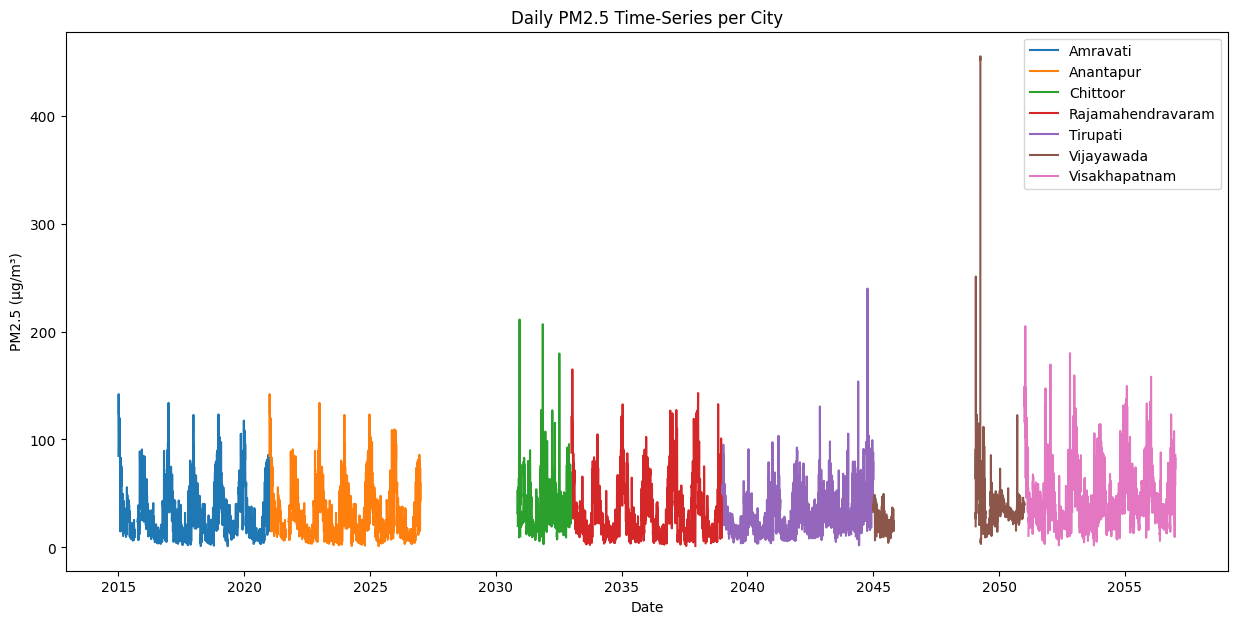

/tmp/ipython-input-1553182488.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Season", y="pm2_5", data=daily_df, palette="Set2")


<Figure size 640x480 with 0 Axes>

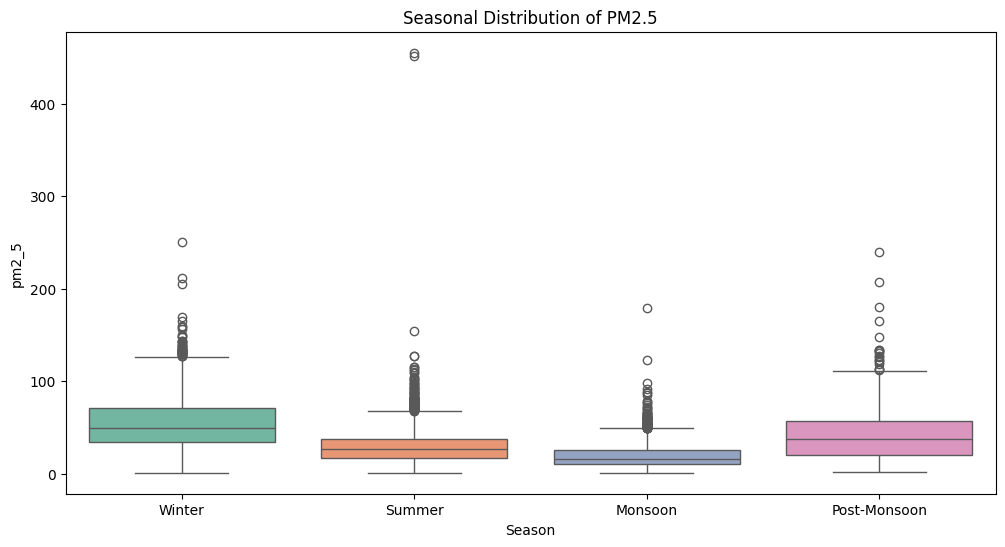

<Figure size 640x480 with 0 Axes>

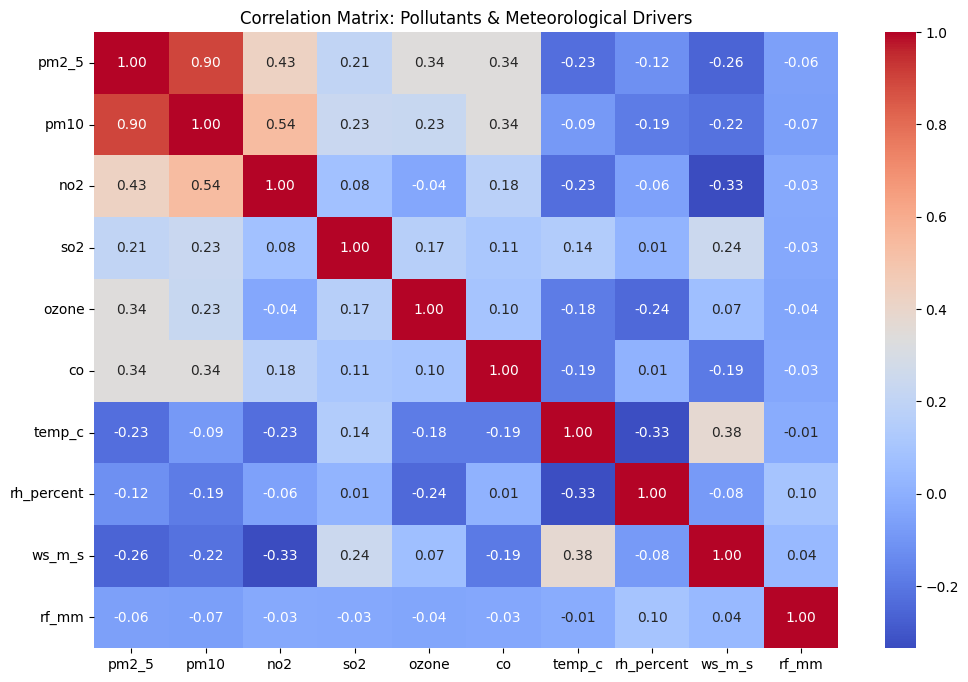

<Figure size 640x480 with 0 Axes>

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
import folium
from geopy.geocoders import Nominatim
import time

print(daily_df.columns)

# --- Visualization 1: Time-series Plot for PM2.5 ---
plt.figure(figsize=(15, 7))
for city, grp in daily_df.groupby('City'):
    plt.plot(grp.index, grp['pm2_5'], label=city)

plt.title("Daily PM2.5 Time-Series per City")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()
plt.savefig("Daily PM2.5 Time-Series per City.png")

# --- Visualization 2: Seasonal Boxplots ---
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8, 9]:
        return "Monsoon"
    else:
        return "Post-Monsoon"

daily_df['Season'] = daily_df.index.month.map(assign_season)

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x="Season", y="pm2_5", data=daily_df, palette="Set2")
plt.title("Seasonal Distribution of PM2.5")
plt.show()
plt.savefig("Seasonal Distribution of PM2.5.png")

# --- Visualization 3: Correlation Heatmap ---

all_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'ozone', 'co',
            'temp_c', 'rh_percent', 'ws_m_s', 'rf_mm']
corr = daily_df[all_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Pollutants & Meteorological Drivers")
plt.show()
plt.savefig("Correlation Matrix: Pollutants & Meteorological Drivers.png")

#####################################

city_coords = {
    "Amravati": (16.5131, 80.5165),
    "Anantpur": (14.6824, 77.6017),
    "Chittoor": (13.2172, 79.1003),
    "Rajamahendravaram": (17.0005, 81.8040),
    "Tirupati": (13.6288, 79.4192),
    "Vijayawada": (16.5062, 80.6480),
    "Visakhapatnam": (17.6868, 83.2185)
    # add more cities as per your dataset
}

city_map = folium.Map(location=[15.9, 80.0], zoom_start=7)

for city, grp in daily_df.groupby('City'):
    if city in city_coords:
        lat, lon = city_coords[city]
        folium.Marker(
            location=[lat, lon],
            popup=city,
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(city_map)

city_map.save("City_Map.html")

#####################################


In [42]:
# Correlation Table

# Meteorological features
met_features = ['temp_c', 'rh_percent', 'ws_m_s', 'rf_mm']

# Pollutants
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'ozone']

# Pearson correlation
pearson_corr = daily_df[pollutants + met_features].corr(method='pearson')
print("Pearson Correlation Table:")
print(pearson_corr.loc[pollutants, met_features])

# Spearman correlation
spearman_corr = daily_df[pollutants + met_features].corr(method='spearman')
print("Spearman Correlation Table:")
print(spearman_corr.loc[pollutants, met_features])


Pearson Correlation Table:
         temp_c  rh_percent    ws_m_s     rf_mm
pm2_5 -0.226353   -0.116987 -0.259277 -0.059188
pm10  -0.086072   -0.187802 -0.216454 -0.068369
no2   -0.229655   -0.057296 -0.334996 -0.025179
so2    0.141819    0.014690  0.244352 -0.027489
co    -0.188828    0.012576 -0.190957 -0.034437
ozone -0.184003   -0.242647  0.071755 -0.041022
Spearman Correlation Table:
         temp_c  rh_percent    ws_m_s     rf_mm
pm2_5 -0.216777   -0.175276 -0.290662 -0.343115
pm10  -0.079442   -0.251749 -0.213705 -0.351192
no2   -0.246953   -0.007921 -0.445825 -0.082764
so2    0.180754    0.025050  0.299677 -0.072796
co    -0.259376    0.011858 -0.217576 -0.060499
ozone -0.183940   -0.218898  0.085384 -0.187261


In [43]:
# Linear Regression Output

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm

results_lr = {}

for pollutant in pollutants:
    data = daily_df[met_features + [pollutant]].dropna()
    if len(data) < 30:
        continue

    X = data[met_features]
    y = data[pollutant]

    # Using statsmodels for detailed regression output
    X_sm = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X_sm).fit()

    print(f"\nRegression Output for {pollutant}:")
    print(model.summary())

    results_lr[pollutant] = model.rsquared  # variance explained


Regression Output for pm2_5:
                            OLS Regression Results                            
Dep. Variable:                  pm2_5   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     456.8
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:45:21   Log-Likelihood:                -55991.
No. Observations:               12217   AIC:                         1.120e+05
Df Residuals:                   12212   BIC:                         1.120e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.8625 

In [44]:
# Feature importance (Random Forest example)

from sklearn.ensemble import RandomForestRegressor
import numpy as np

feature_importances = pd.DataFrame(index=met_features)

for pollutant in pollutants:
    data = daily_df[met_features + [pollutant]].dropna()
    if len(data) < 30:
        continue

    X = data[met_features]
    y = data[pollutant]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    fi = rf.feature_importances_
    feature_importances[pollutant] = fi

# Display feature importances
print("Feature Importances (Random Forest):")
print(feature_importances)

Feature Importances (Random Forest):
               pm2_5      pm10       no2       so2        co     ozone
temp_c      0.347114  0.284650  0.317461  0.305328  0.346560  0.346551
rh_percent  0.269238  0.286346  0.283309  0.306930  0.308841  0.319864
ws_m_s      0.292008  0.329658  0.365339  0.338338  0.310401  0.286946
rf_mm       0.091640  0.099346  0.033892  0.049404  0.034197  0.046638


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R²: 0.268, RMSE: 21.574


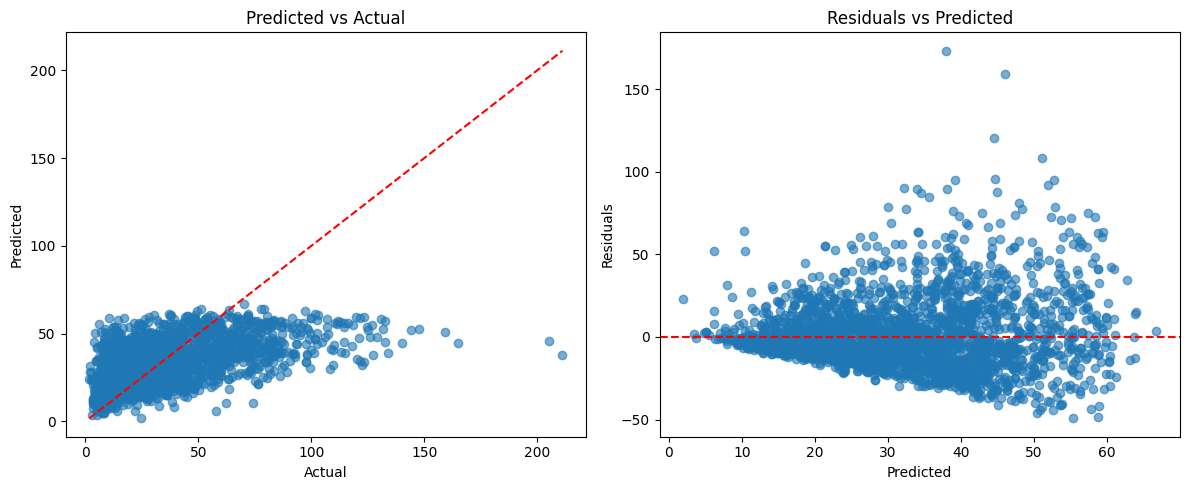

<Figure size 640x480 with 0 Axes>

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- 1. Prepare features and target ---
data = daily_df[['pm2_5', 'ws_m_s', 'temp_c', 'rh_percent', 'rf_mm']].dropna()

X = data[['ws_m_s', 'temp_c', 'rh_percent', 'rf_mm']].dropna()
y = data['pm2_5'].loc[X.index]  # ensure indices match

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. Build ANN model ---
model = Sequential([
    Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)  # output layer for regression
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)

# --- 5. Predictions ---
y_pred = model.predict(X_test_scaled).flatten()

mask = ~np.isnan(y_test) & ~np.isnan(y_pred)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# --- 6. Model evaluation ---
r2 = r2_score(y_test_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))  # manual sqrt
print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

# --- 7. Diagnostic plots ---
residuals = y_test - y_pred

plt.figure(figsize=(12, 5))

# Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")

# Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

plt.tight_layout()
plt.show()
plt.savefig("model diagnostics.png")